# Random Forest ile Maaş Sınıflandırma
Bu kod "Dataset salary 2024" veri setini kullanarak çalışanların deneyim seviyelerini tahmin etmek için bir Random Forest sınıflandırma modeli oluşturur.

1. Gerekli kütüphanelerin yüklenmesi.
2. Veri setinin yüklenmesi ve ön işleme (nadir görülen iş unvanlarının filtrelenmesi).
3. Kategorik değişkenlerin kodlanması (One-Hot ve Ordinal Encoding).
4. Verinin eğitim ve test setlerine ayrılması.
5. Random Forest modelinin eğitilmesi.
6. Modelin performansının değerlendirilmesi ve görselleştirilmesi.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier

## Veri Yükleme ve Filtreleme
Veri setini yüklüyoruz ve 'job titles' sütunundaki az sayıda bulunan verileri veri setinden çıkarmak yerine overfittingi önlemek için yeni isimlerde grupluyoruz. Bu satırları çıkartmamız durumunda modelimiz target sütununda az sayıda bulunan verileri tahmin etme noktasında düşük performans vermektedir. 

In [26]:
#Veriyi değişkene atama
data = pd.read_csv('Dataset salary 2024.csv')
data.dropna(inplace=True)
#Veride gürültünün fazla olduğu 'job_title' sütununu filtrleyip yeni isimlerde gruplama
valid_percentage = len(data) * 0.02
job_counts = data['job_title'].value_counts()
rare_jobs = job_counts[job_counts < valid_percentage].index
for exp_level in ['EX', 'MI', 'EN', 'SE']:
    mask = (data['job_title'].isin(rare_jobs)) & (data['experience_level'] == exp_level)
    if mask.sum() > 0:
        new_title = f"other{exp_level}"
        data.loc[mask, 'job_title'] = new_title
job_counts = data['job_title'].value_counts()
valid_jobs = job_counts[job_counts >= valid_percentage].index
other_titles = [title for title in data['job_title'].unique() if str(title).startswith('other')]
valid_jobs = valid_jobs.union(other_titles)
#Filtrelenmiş veriyi yeni bir dataframe'e kopyalama
data_filtered = data[data['job_title'].isin(valid_jobs)].copy()
#Kontrol için sonucu ekrana yazdırma
print(f"Veri sayısı: {len(data)}")
print(f"Filtrelenmiş veri sayısı: {len(data_filtered)}")

Veri sayısı: 16534
Filtrelenmiş veri sayısı: 16534


## Özelliklerin ve Hedef Değişkenin Belirlenmesi
Tahmin etmek istediğimiz hedef sütun 'experience_level'. 
Modeli eğitmek için kullanacağımız özellikler ise şunlardır:
- 'salary_in_usd': Maaş
- 'work_year': Çalışma yılı
- 'employment_type': Çalışma tipi(tam zamanlı, yarı zamanlı vb.)
- 'job_title': İş unvanı
- 'remote_ratio': Uzaktan çalışma oranı
- 'company_size': Şirket büyüklüğü
- 'company_location': Şirket konumu

In [27]:
#Filtrelenmiş verideki target ve feature sütunlarını ayarlama
target = 'experience_level'
features = ['salary_in_usd', 'work_year', 'employment_type', 'job_title', 'remote_ratio', 'company_size', 'company_location']
#Sütunları X ve Y değerlerine atama
X = data_filtered[features]
y = data_filtered[target]

## Ön İşleme (Preprocessing)
Makine öğrenmesi modelleri genellikle sayısal verilerle çalışır. Bu nedenle kategorik verileri dönüştürmemiz gerekir:
- Ordinal Encoding: 'company_size' gibi sıralı bir anlam ifade eden değişkenler için kullanılır.
- One-Hot Encoding: 'job_title' veya 'company_location' gibi sıralı olmayan nominal değişkenler için kullanılır.

In [28]:
#Sıralı ifadeler
ordinal_cols = ['company_size']
ordinal_vals = [['S', 'M', 'L']]
#Nominal ifadeler
nominal_cols = ['employment_type', 'job_title', 'company_location', 'remote_ratio', 'work_year']
#Ön işleme ile veriyi hazırlama
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=ordinal_vals), ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols)
    ],
    remainder='passthrough'
)

## Model Eğitimi
Veriyi %80 eğitim ve %20 test seti olarak ayırıp Pipeline ile preprocessing adımlarını ve modelleri birleştiriyoruz bu sayede veriye dönüşümler otomatik olarak uygulanır. Bir döngü yardımı ile hangi modelin en iyi sonucu verdiğini belirliyoruz.

In [29]:
#Veriyi böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Denenecek modelleri bir matris içinde topla
models= [
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Desicion Tree", DecisionTreeClassifier(random_state=42)),
    #("LinR", LinearRegression()),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42))
]
#Döngüyle matris içindeki modelleri pipeline ile birleştirerek başarı oranları arasındaki farka bak
for name,model in models:
    #Modeli pipeline içinde hazırla
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    #Modeli eğit
    model_pipeline.fit(X_train, y_train)
    print(f"{name} için doğruluk (Accuracy): {model_pipeline.score(X_test, y_test):.5f}")


Logistic Regression için doğruluk (Accuracy): 0.65558
Desicion Tree için doğruluk (Accuracy): 0.76474
Gradient Boosting için doğruluk (Accuracy): 0.78077
Random Forest için doğruluk (Accuracy): 0.78228


## Model Değerlendirmesi

Modelin başarısını bulmak için accuracy score'u hesaplıyoruz ve modelin hangi sınıfları doğru, hangilerini yanlış tahmin ettiğini görmek için Confusion Matrix çizdiriyoruz.

<Figure size 1000x800 with 0 Axes>

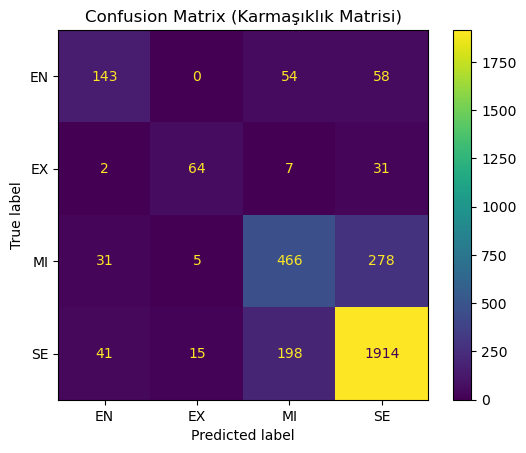

In [31]:


#Matplotlib ile görselleştirme
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test)
plt.title('Confusion Matrix (Karmaşıklık Matrisi)')
plt.show()



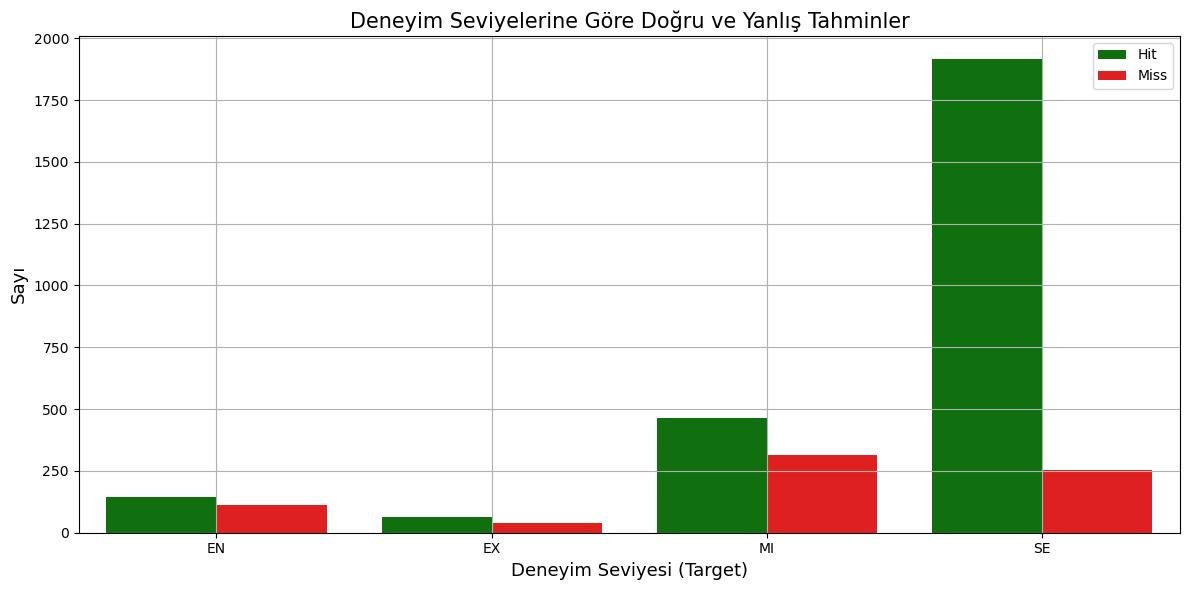

In [34]:
y_pred = model_pipeline.predict(X_test)
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

#Hit ve Miss sütunlarını ekleme
comparison_df['Outcome'] = comparison_df.apply(
    lambda row: 'Hit' if row['Actual'] == row['Predicted'] else 'Miss', axis=1
)

#Veriyi Hit/Miss olarak gruplama
plot_data = comparison_df.groupby(['Actual', 'Outcome']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))

#Sütun grafiği oluştur
sns.barplot(
    data=plot_data, 
    x='Actual', 
    y='Count', 
    hue='Outcome', 
    palette={'Hit': 'green', 'Miss': 'red'}
)

plt.title('Deneyim Seviyelerine Göre Doğru ve Yanlış Tahminler', fontsize=15)
plt.xlabel('Deneyim Seviyesi (Target)', fontsize=13)
plt.ylabel('Sayı', fontsize=13)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

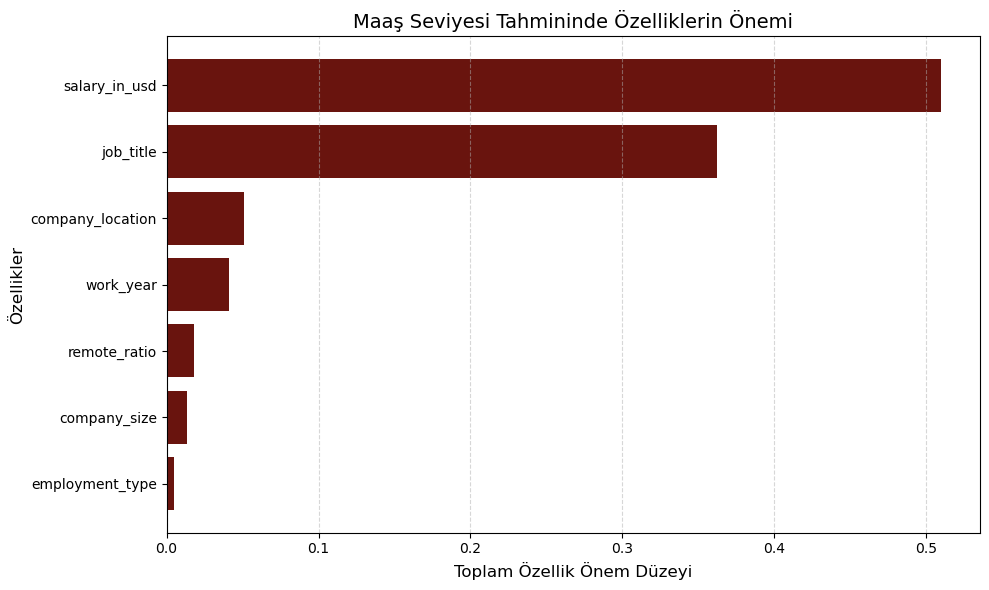

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

classifier = model_pipeline.named_steps['classifier']
preprocessor = model_pipeline.named_steps['preprocessor']
feature_names_out = preprocessor.get_feature_names_out()
importances = classifier.feature_importances_
original_features = ['salary_in_usd', 'work_year', 'employment_type', 'job_title', 'remote_ratio', 'company_size', 'company_location']

aggregated_importances = {feature: 0.0 for feature in original_features}

for feature_name, importance in zip(feature_names_out, importances):
    for orig_feature in original_features:
        if orig_feature in feature_name:
            aggregated_importances[orig_feature] += importance
            break

importance_df = pd.DataFrame(list(aggregated_importances.items()), columns=['Özellikler', 'Önem Düzeyi'])
importance_df = importance_df.sort_values(by='Önem Düzeyi', ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Özellikler'], importance_df['Önem Düzeyi'], color='#69140E') # Görseldeki maroon/koyu kırmızı tonu

plt.title('Maaş Seviyesi Tahmininde Özelliklerin Önemi', fontsize=14)
plt.xlabel('Toplam Özellik Önem Düzeyi', fontsize=12)
plt.ylabel('Özellikler', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## SONUÇ

Bütün işlemeler sonucunda oluşturulan modelimiz %78 başarı oranı ile 'experience_level' sütununu tahmin ediyor. Başarı oranının bu seviyede olmasının sebebi ise görsellerden de anlaşılabileceği gibi veri setimizde 'experience_level' sütunundaki 'EN','EX' ve 'MI' değerlerinin az sayıda bulunmasıdır. Yeterince veri bulunan 'SE' değeri için alınan sonuçların başarı oranı model başarısından daha yüksektir. 'experience_level' sütununu tahmin etmek için en önemli özellik 'salary_in_usd' sütunudur, bu ikisi yüksek oranda korelasyon gösterir. 'employment_type' sütunuyla ise düşük oranda korelasyon gösterir.